In [2]:
%load_ext autoreload
%autoreload 2
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import pickle as pkl
import scipy
from radis import calc_spectrum
from radis import load_spec
from radis.test.utils import getTestFile
from radis import Spectrum

from inversion_tools_remastered import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Regularised inversion code

Functions are defined in `inversion_tools`. We first define a few parameters, such as the species of interest, and the spectral ranges. We then load up the data, and subset things spectrally.


In [3]:
# Species and spectral bounds (in cm^{-1}) as a dictionary.
bounds = {
    "CO2": (6250, 6600),
    "CH4": [9100, 9700],
    "H2O": [5500, 5900],
    "CO": [2500, 4000],
}
selected_spectra = list(bounds.keys())

(spectra_obs, absorption_spectra, species_names, wv_obs) = read_data(
    selected_spectra,
    "spectra/test_series/", # Location of the series we want to invert.
    "spectra/templates/" # Location of the individual species "template" absorption
)

100%|██████████| 4/4 [00:00<00:00, 44.73it/s]


In [4]:
import pickle
with open('compounds' + 'CH3OH' + '.pickle', 'rb') as handle:
    Compounds = pickle.load(handle)

In [5]:
bad = ['SiH', 'CaF', 'SiS', 'CH3Br', 'H2S', 'BeH', 'SH', 'TiH', 'LiF', 'ClO']

for b in bad:
    Compounds.pop(b)

In [6]:
from pathlib import Path
Freq_obs = np.array(wv_obs)
folder = Path("Calibration/")
files = {f.name:f for f in sorted(folder.rglob("**/*_1ppm_*"))
        if int(f.name.split("_")[3].split(" ")[-1]) > 800}

def getReferenceMatrix(Compounds, T, P, W_obs):
    
    output = []
    
    for c in Compounds:
        
        bank = Compounds[c]['Source']
        
        tmp = np.zeros_like(W_obs)
        
        for i in range(len(Compounds[c]['bounds'])):
            bound = Compounds[c]['bounds'][i]
            try:
                print(c, bound, bank)
                s = calc_spectrum(bound[0], bound[1],         # cm-1
                          molecule=c,
                          isotope='1',
                          pressure=P,   # bar
                          Tgas=T,           # K
                          mole_fraction=10**(-4),
                          path_length=500,      # cm
                          databank=bank,  # or 'hitemp', 'geisa', 'exomol'
                          )
            except:
                print("BAD", c)
                continue
            s.apply_slit(0.241, 'cm-1', shape="gaussian")       # simulate an experimental slit
            w, A = s.get('absorbance', wunit='cm-1')
           
            iloc, jloc = np.argmin(np.abs(w.min() - W_obs)), np.argmin(np.abs(w.max() - W_obs))
            s.resample(W_obs[iloc:jloc], energy_threshold=2)
            
            w, A = s.get('absorbance', wunit='cm-1')

            tmp[iloc:jloc] = A
            
        output.append(tmp)
    
    ref_mat = np.array(output)
    
    return ref_mat

T, P = 300, 1.01

storage_mtx = getReferenceMatrix(Compounds, T, P, wv_obs)

C2H2 [625, 830] hitran
HAPI version: 1.2.2.0
To get the most up-to-date version please check http://hitran.org/hapi
ATTENTION: Python versions of partition sums from TIPS-2021 are now available in HAPI code

           MIT license: Copyright 2021 HITRAN team, see more at http://hitran.org. 

           If you use HAPI in your research or software development,
           please cite it using the following reference:
           R.V. Kochanov, I.E. Gordon, L.S. Rothman, P. Wcislo, C. Hill, J.S. Wilzewski,
           HITRAN Application Programming Interface (HAPI): A comprehensive approach
           to working with spectroscopic data, J. Quant. Spectrosc. Radiat. Transfer 177, 15-30 (2016)
           DOI: 10.1016/j.jqsrt.2016.03.005

           ATTENTION: This is the core version of the HITRAN Application Programming Interface.
                      For more efficient implementation of the absorption coefficient routine, 
                      as well as for new profiles, parameters and o

Calculating Equilibrium Spectrum
Physical Conditions
----------------------------------------
   Tgas                 300 K
   Trot                 300 K
   Tvib                 300 K
   isotope              1
   mole_fraction        0.0001
   molecule             CO
   overpopulation       None
   path_length          500 cm
   pressure_mbar        1010.0 mbar
   rot_distribution     boltzmann
   self_absorption      True
   state                X
   vib_distribution     boltzmann
   wavenum_max          4350.0000 cm-1
   wavenum_min          4100.0000 cm-1
Computation Parameters
----------------------------------------
   Tref                 296 K
   add_at_used          
   broadening_method    voigt
   cutoff               1e-27 cm-1/(#.cm-2)
   dbformat             hitran
   dbpath               C:\Users\luker\.radisdb\hitran\CO.hdf5
   diluent              air
   folding_thresh       1e-06
   include_neighbouring_lines  True
   memory_mapping_engine  auto
   neighbour_lines     

C:\Users\luker\Anaconda3\envs\Flaming_Radis\lib\site-packages\radis\misc\warning.py:369: AccuracyWarning: Some lines are too narrow (FWHM ~ 0.022 cm⁻¹) for the current spectral grid (wstep=0.01). Please reduce wstep to below 0.0072 cm⁻¹. You can use wstep='auto' to get the optimal spectral grid value. You can also ignore by setting `warnings={'AccuracyWarning':'ignore'}` or change the 'GRIDPOINTS_PER_LINEWIDTH_WARN_THRESHOLD' key of radis.config / your ~/radis.json (if you know what you're doing!)
  warnings.warn(WarningType(message))


0.27s - Spectrum calculated
NO [1700, 2000] hitran
Calculating Equilibrium Spectrum
Physical Conditions
----------------------------------------
   Tgas                 300 K
   Trot                 300 K
   Tvib                 300 K
   isotope              1
   mole_fraction        0.0001
   molecule             NO
   overpopulation       None
   path_length          500 cm
   pressure_mbar        1010.0 mbar
   rot_distribution     boltzmann
   self_absorption      True
   state                X
   vib_distribution     boltzmann
   wavenum_max          2000.0000 cm-1
   wavenum_min          1700.0000 cm-1
Computation Parameters
----------------------------------------
   Tref                 296 K
   add_at_used          
   broadening_method    voigt
   cutoff               1e-27 cm-1/(#.cm-2)
   dbformat             hitran
   dbpath               C:\Users\luker\.radisdb\hitran\NO.hdf5
   diluent              air
   folding_thresh       1e-06
   include_neighbouring_lines  True
   

C:\Users\luker\Anaconda3\envs\Flaming_Radis\lib\site-packages\radis\misc\warning.py:369: AccuracyWarning: Some lines are too narrow (FWHM ~ 0.02 cm⁻¹) for the current spectral grid (wstep=0.01). Please reduce wstep to below 0.0066 cm⁻¹. You can use wstep='auto' to get the optimal spectral grid value. You can also ignore by setting `warnings={'AccuracyWarning':'ignore'}` or change the 'GRIDPOINTS_PER_LINEWIDTH_WARN_THRESHOLD' key of radis.config / your ~/radis.json (if you know what you're doing!)
  warnings.warn(WarningType(message))


0.24s - Spectrum calculated
HCl [5200, 5900] hitran
Calculating Equilibrium Spectrum
Physical Conditions
----------------------------------------
   Tgas                 300 K
   Trot                 300 K
   Tvib                 300 K
   isotope              1
   mole_fraction        0.0001
   molecule             HCl
   overpopulation       None
   path_length          500 cm
   pressure_mbar        1010.0 mbar
   rot_distribution     boltzmann
   self_absorption      True
   state                X
   vib_distribution     boltzmann
   wavenum_max          5900.0000 cm-1
   wavenum_min          5200.0000 cm-1
Computation Parameters
----------------------------------------
   Tref                 296 K
   add_at_used          
   broadening_method    voigt
   cutoff               1e-27 cm-1/(#.cm-2)
   dbformat             hitran
   dbpath               C:\Users\luker\.radisdb\hitran\HCl.hdf5
   diluent              air
   folding_thresh       1e-06
   include_neighbouring_lines  True


C:\Users\luker\Anaconda3\envs\Flaming_Radis\lib\site-packages\radis\misc\warning.py:369: AccuracyWarning: Some lines are too narrow (FWHM ~ 0.025 cm⁻¹) for the current spectral grid (wstep=0.01). Please reduce wstep to below 0.0083 cm⁻¹. You can use wstep='auto' to get the optimal spectral grid value. You can also ignore by setting `warnings={'AccuracyWarning':'ignore'}` or change the 'GRIDPOINTS_PER_LINEWIDTH_WARN_THRESHOLD' key of radis.config / your ~/radis.json (if you know what you're doing!)
  warnings.warn(WarningType(message))


0.20s - Spectrum calculated
NH [2800, 3450] exomol
Using ExoMol database MoLLIST for 14N-1H
Background atmosphere:  Air
Error: Couldn't download .broad file at http://www.exomol.com/db/NH/14N-1H/14N-1H__H2.broad and save.
Error: Couldn't download .broad file at http://www.exomol.com/db/NH/14N-1H/14N-1H__He.broad and save.
Error: Couldn't download .broad file at http://www.exomol.com/db/NH/14N-1H/14N-1H__air.broad and save.
Reading C:\Users\luker\.radisdb\exomol\NH\14N-1H\MoLLIST\14N-1H__MoLLIST.trans.bz2
.broad is used.
Calculating Equilibrium Spectrum
Physical Conditions
----------------------------------------
   Tgas                 300 K
   Trot                 300 K
   Tvib                 300 K
   isotope              1
   mole_fraction        0.0001
   molecule             NH
   overpopulation       None
   path_length          500 cm
   pressure_mbar        1010.0 mbar
   rot_distribution     boltzmann
   self_absorption      True
   state                X
   vib_distribution  

C:\Users\luker\Anaconda3\envs\Flaming_Radis\lib\site-packages\radis\api\exomolapi.py:1189: Warning: 
                    No default broadening exponent in def file. Assigned n = 0.5
                    
  warnings.warn(
C:\Users\luker\Anaconda3\envs\Flaming_Radis\lib\site-packages\radis\api\exomolapi.py:1199: Warning: 
                    No default broadening in def file. Assigned alpha_ref = 0.07
                    
  warnings.warn(
C:\Users\luker\Anaconda3\envs\Flaming_Radis\lib\site-packages\radis\misc\warning.py:369: MissingPressureShiftWarning: Pressure-shift coefficient not given in database: assumed 0 pressure shift
  warnings.warn(WarningType(message))


0.07s - Spectrum calculated
SiH2 [800, 1300] exomol
Using ExoMol database CATS for 28Si-1H2 (recommended by the ExoMol team). All available databases are ['xsec-CATS', 'CATS']. Select one of them with `radis.fetch_exomol(DATABASE_NAME)`, `SpectrumFactory.fetch_databank('exomol', exomol_database=DATABASE_NAME')`, or `calc_spectrum(..., databank=('exomol', DATABASE_NAME))` 

Background atmosphere:  Air
Error: Couldn't download .broad file at http://www.exomol.com/db/SiH2/28Si-1H2/28Si-1H2__H2.broad and save.
Error: Couldn't download .broad file at http://www.exomol.com/db/SiH2/28Si-1H2/28Si-1H2__He.broad and save.
Error: Couldn't download .broad file at http://www.exomol.com/db/SiH2/28Si-1H2/28Si-1H2__air.broad and save.
Reading C:\Users\luker\.radisdb\exomol\SiH2\28Si-1H2\CATS\28Si-1H2__CATS__00000-01000.trans.bz2
Reading C:\Users\luker\.radisdb\exomol\SiH2\28Si-1H2\CATS\28Si-1H2__CATS__01000-02000.trans.bz2
.broad is used.
Calculating Equilibrium Spectrum
Physical Conditions
----------

C:\Users\luker\Anaconda3\envs\Flaming_Radis\lib\site-packages\radis\misc\warning.py:369: MissingPressureShiftWarning: Pressure-shift coefficient not given in database: assumed 0 pressure shift
  warnings.warn(WarningType(message))


1.42s - Spectrum calculated
SiH2 [1800, 2200] exomol
Using ExoMol database CATS for 28Si-1H2 (recommended by the ExoMol team). All available databases are ['xsec-CATS', 'CATS']. Select one of them with `radis.fetch_exomol(DATABASE_NAME)`, `SpectrumFactory.fetch_databank('exomol', exomol_database=DATABASE_NAME')`, or `calc_spectrum(..., databank=('exomol', DATABASE_NAME))` 

Background atmosphere:  Air
Error: Couldn't download .broad file at http://www.exomol.com/db/SiH2/28Si-1H2/28Si-1H2__H2.broad and save.
Error: Couldn't download .broad file at http://www.exomol.com/db/SiH2/28Si-1H2/28Si-1H2__He.broad and save.
Error: Couldn't download .broad file at http://www.exomol.com/db/SiH2/28Si-1H2/28Si-1H2__air.broad and save.
Reading C:\Users\luker\.radisdb\exomol\SiH2\28Si-1H2\CATS\28Si-1H2__CATS__01000-02000.trans.bz2
Reading C:\Users\luker\.radisdb\exomol\SiH2\28Si-1H2\CATS\28Si-1H2__CATS__02000-03000.trans.bz2
.broad is used.
Calculating Equilibrium Spectrum
Physical Conditions
---------

C:\Users\luker\Anaconda3\envs\Flaming_Radis\lib\site-packages\radis\misc\warning.py:369: MissingPressureShiftWarning: Pressure-shift coefficient not given in database: assumed 0 pressure shift
  warnings.warn(WarningType(message))


2.33s - Spectrum calculated
SiH2 [2750, 3250] exomol
Using ExoMol database CATS for 28Si-1H2 (recommended by the ExoMol team). All available databases are ['xsec-CATS', 'CATS']. Select one of them with `radis.fetch_exomol(DATABASE_NAME)`, `SpectrumFactory.fetch_databank('exomol', exomol_database=DATABASE_NAME')`, or `calc_spectrum(..., databank=('exomol', DATABASE_NAME))` 

Background atmosphere:  Air
Error: Couldn't download .broad file at http://www.exomol.com/db/SiH2/28Si-1H2/28Si-1H2__H2.broad and save.
Error: Couldn't download .broad file at http://www.exomol.com/db/SiH2/28Si-1H2/28Si-1H2__He.broad and save.
Error: Couldn't download .broad file at http://www.exomol.com/db/SiH2/28Si-1H2/28Si-1H2__air.broad and save.
Reading C:\Users\luker\.radisdb\exomol\SiH2\28Si-1H2\CATS\28Si-1H2__CATS__02000-03000.trans.bz2
Reading C:\Users\luker\.radisdb\exomol\SiH2\28Si-1H2\CATS\28Si-1H2__CATS__03000-04000.trans.bz2
.broad is used.
Calculating Equilibrium Spectrum
Physical Conditions
---------

C:\Users\luker\Anaconda3\envs\Flaming_Radis\lib\site-packages\radis\misc\warning.py:369: MissingPressureShiftWarning: Pressure-shift coefficient not given in database: assumed 0 pressure shift
  warnings.warn(WarningType(message))


2.54s - Spectrum calculated
SiH2 [3700, 4200] exomol
Using ExoMol database CATS for 28Si-1H2 (recommended by the ExoMol team). All available databases are ['xsec-CATS', 'CATS']. Select one of them with `radis.fetch_exomol(DATABASE_NAME)`, `SpectrumFactory.fetch_databank('exomol', exomol_database=DATABASE_NAME')`, or `calc_spectrum(..., databank=('exomol', DATABASE_NAME))` 

Background atmosphere:  Air
Error: Couldn't download .broad file at http://www.exomol.com/db/SiH2/28Si-1H2/28Si-1H2__H2.broad and save.
Error: Couldn't download .broad file at http://www.exomol.com/db/SiH2/28Si-1H2/28Si-1H2__He.broad and save.
Error: Couldn't download .broad file at http://www.exomol.com/db/SiH2/28Si-1H2/28Si-1H2__air.broad and save.
Reading C:\Users\luker\.radisdb\exomol\SiH2\28Si-1H2\CATS\28Si-1H2__CATS__03000-04000.trans.bz2
Reading C:\Users\luker\.radisdb\exomol\SiH2\28Si-1H2\CATS\28Si-1H2__CATS__04000-05000.trans.bz2
.broad is used.
Calculating Equilibrium Spectrum
Physical Conditions
---------

C:\Users\luker\Anaconda3\envs\Flaming_Radis\lib\site-packages\radis\misc\warning.py:369: MissingPressureShiftWarning: Pressure-shift coefficient not given in database: assumed 0 pressure shift
  warnings.warn(WarningType(message))


6.16s - Spectrum calculated
AlF [700, 850] exomol
Using ExoMol database MoLLIST for 27Al-19F
Background atmosphere:  Air
Error: Couldn't download .broad file at http://www.exomol.com/db/AlF/27Al-19F/27Al-19F__H2.broad and save.
Error: Couldn't download .broad file at http://www.exomol.com/db/AlF/27Al-19F/27Al-19F__He.broad and save.
Error: Couldn't download .broad file at http://www.exomol.com/db/AlF/27Al-19F/27Al-19F__air.broad and save.
Reading C:\Users\luker\.radisdb\exomol\AlF\27Al-19F\MoLLIST\27Al-19F__MoLLIST.trans.bz2


C:\Users\luker\Anaconda3\envs\Flaming_Radis\lib\site-packages\radis\api\exomolapi.py:1189: Warning: 
                    No default broadening exponent in def file. Assigned n = 0.5
                    
  warnings.warn(
C:\Users\luker\Anaconda3\envs\Flaming_Radis\lib\site-packages\radis\api\exomolapi.py:1199: Warning: 
                    No default broadening in def file. Assigned alpha_ref = 0.07
                    
  warnings.warn(


.broad is used.
Calculating Equilibrium Spectrum
Physical Conditions
----------------------------------------
   Tgas                 300 K
   Trot                 300 K
   Tvib                 300 K
   isotope              1
   mole_fraction        0.0001
   molecule             AlF
   overpopulation       None
   path_length          500 cm
   pressure_mbar        1010.0 mbar
   rot_distribution     boltzmann
   self_absorption      True
   state                X
   vib_distribution     boltzmann
   wavenum_max          850.0000 cm-1
   wavenum_min          700.0000 cm-1
Computation Parameters
----------------------------------------
   Tref                 296 K
   add_at_used          
   broadening_method    voigt
   cutoff               1e-27 cm-1/(#.cm-2)
   dbformat             exomol-radisdb
   dbpath               C:\Users\luker\.radisdb\exomol\AlF\27Al-19F\MoLLIST
   diluent              air
   folding_thresh       1e-06
   include_neighbouring_lines  True
   memory_mapping_

C:\Users\luker\Anaconda3\envs\Flaming_Radis\lib\site-packages\radis\misc\warning.py:369: MissingPressureShiftWarning: Pressure-shift coefficient not given in database: assumed 0 pressure shift
  warnings.warn(WarningType(message))


0.20s - Spectrum calculated
CH [2400, 3000] exomol
Using ExoMol database MoLLIST for 12C-1H (recommended by the ExoMol team). All available databases are ['Villanueva', 'MoLLIST']. Select one of them with `radis.fetch_exomol(DATABASE_NAME)`, `SpectrumFactory.fetch_databank('exomol', exomol_database=DATABASE_NAME')`, or `calc_spectrum(..., databank=('exomol', DATABASE_NAME))` 

Background atmosphere:  Air
Error: Couldn't download .broad file at http://www.exomol.com/db/CH/12C-1H/12C-1H__H2.broad and save.
Error: Couldn't download .broad file at http://www.exomol.com/db/CH/12C-1H/12C-1H__He.broad and save.
Error: Couldn't download .broad file at http://www.exomol.com/db/CH/12C-1H/12C-1H__air.broad and save.
Reading C:\Users\luker\.radisdb\exomol\CH\12C-1H\MoLLIST\12C-1H__MoLLIST.trans.bz2
.broad is used.
Calculating Equilibrium Spectrum
Physical Conditions
----------------------------------------
   Tgas                 300 K
   Trot                 300 K
   Tvib                 300 K
  

C:\Users\luker\Anaconda3\envs\Flaming_Radis\lib\site-packages\radis\misc\warning.py:369: MissingPressureShiftWarning: Pressure-shift coefficient not given in database: assumed 0 pressure shift
  warnings.warn(WarningType(message))


0.21s - Spectrum calculated
CO2 [2260, 2400] hitran
Calculating Equilibrium Spectrum
Physical Conditions
----------------------------------------
   Tgas                 300 K
   Trot                 300 K
   Tvib                 300 K
   isotope              1
   mole_fraction        0.0001
   molecule             CO2
   overpopulation       None
   path_length          500 cm
   pressure_mbar        1010.0 mbar
   rot_distribution     boltzmann
   self_absorption      True
   state                X
   vib_distribution     boltzmann
   wavenum_max          2400.0000 cm-1
   wavenum_min          2260.0000 cm-1
Computation Parameters
----------------------------------------
   Tref                 296 K
   add_at_used          
   broadening_method    voigt
   cutoff               1e-27 cm-1/(#.cm-2)
   dbformat             hitran
   dbpath               C:\Users\luker\.radisdb\hitran\CO2.hdf5
   diluent              air
   folding_thresh       1e-06
   include_neighbouring_lines  True


AlH [1350, 1800] exomol
Using ExoMol database AlHambra for 27Al-1H (recommended by the ExoMol team). All available databases are ['xsec-AlHambra', 'AlHambra']. Select one of them with `radis.fetch_exomol(DATABASE_NAME)`, `SpectrumFactory.fetch_databank('exomol', exomol_database=DATABASE_NAME')`, or `calc_spectrum(..., databank=('exomol', DATABASE_NAME))` 

Background atmosphere:  Air
Error: Couldn't download .broad file at http://www.exomol.com/db/AlH/27Al-1H/27Al-1H__H2.broad and save.
Error: Couldn't download .broad file at http://www.exomol.com/db/AlH/27Al-1H/27Al-1H__He.broad and save.
Error: Couldn't download .broad file at http://www.exomol.com/db/AlH/27Al-1H/27Al-1H__air.broad and save.
Reading C:\Users\luker\.radisdb\exomol\AlH\27Al-1H\AlHambra\27Al-1H__AlHambra.trans.bz2
.broad is used.
Calculating Equilibrium Spectrum
Physical Conditions
----------------------------------------
   Tgas                 300 K
   Trot                 300 K
   Tvib                 300 K
   isotop

C:\Users\luker\Anaconda3\envs\Flaming_Radis\lib\site-packages\radis\misc\warning.py:369: MissingPressureShiftWarning: Pressure-shift coefficient not given in database: assumed 0 pressure shift
  warnings.warn(WarningType(message))


0.23s - Spectrum calculated
AlH [3000, 3200] exomol
Using ExoMol database AlHambra for 27Al-1H (recommended by the ExoMol team). All available databases are ['xsec-AlHambra', 'AlHambra']. Select one of them with `radis.fetch_exomol(DATABASE_NAME)`, `SpectrumFactory.fetch_databank('exomol', exomol_database=DATABASE_NAME')`, or `calc_spectrum(..., databank=('exomol', DATABASE_NAME))` 

Background atmosphere:  Air
Error: Couldn't download .broad file at http://www.exomol.com/db/AlH/27Al-1H/27Al-1H__H2.broad and save.
Error: Couldn't download .broad file at http://www.exomol.com/db/AlH/27Al-1H/27Al-1H__He.broad and save.
Error: Couldn't download .broad file at http://www.exomol.com/db/AlH/27Al-1H/27Al-1H__air.broad and save.
Reading C:\Users\luker\.radisdb\exomol\AlH\27Al-1H\AlHambra\27Al-1H__AlHambra.trans.bz2
.broad is used.
Calculating Equilibrium Spectrum
Physical Conditions
----------------------------------------
   Tgas                 300 K
   Trot                 300 K
   Tvib    

C:\Users\luker\Anaconda3\envs\Flaming_Radis\lib\site-packages\radis\misc\warning.py:369: MissingPressureShiftWarning: Pressure-shift coefficient not given in database: assumed 0 pressure shift
  warnings.warn(WarningType(message))


0.17s - Spectrum calculated
N2O [1100, 1350] hitran
Calculating Equilibrium Spectrum
Physical Conditions
----------------------------------------
   Tgas                 300 K
   Trot                 300 K
   Tvib                 300 K
   isotope              1
   mole_fraction        0.0001
   molecule             N2O
   overpopulation       None
   path_length          500 cm
   pressure_mbar        1010.0 mbar
   rot_distribution     boltzmann
   self_absorption      True
   state                X
   vib_distribution     boltzmann
   wavenum_max          1350.0000 cm-1
   wavenum_min          1100.0000 cm-1
Computation Parameters
----------------------------------------
   Tref                 296 K
   add_at_used          
   broadening_method    voigt
   cutoff               1e-27 cm-1/(#.cm-2)
   dbformat             hitran
   dbpath               C:\Users\luker\.radisdb\hitran\N2O.hdf5
   diluent              air
   folding_thresh       1e-06
   include_neighbouring_lines  True


C:\Users\luker\Anaconda3\envs\Flaming_Radis\lib\site-packages\radis\misc\warning.py:369: MissingPressureShiftWarning: Pressure-shift coefficient not given in database: assumed 0 pressure shift
  warnings.warn(WarningType(message))


CaH [2300, 2570] exomol
Using ExoMol database XAB for 40Ca-1H (recommended by the ExoMol team). All available databases are ['MoLLIST-CaH', 'Yadin', 'UGAMOP', 'xsec-XAB', 'XAB']. Select one of them with `radis.fetch_exomol(DATABASE_NAME)`, `SpectrumFactory.fetch_databank('exomol', exomol_database=DATABASE_NAME')`, or `calc_spectrum(..., databank=('exomol', DATABASE_NAME))` 

Background atmosphere:  Air
Error: Couldn't download .broad file at http://www.exomol.com/db/CaH/40Ca-1H/40Ca-1H__H2.broad and save.
Error: Couldn't download .broad file at http://www.exomol.com/db/CaH/40Ca-1H/40Ca-1H__He.broad and save.
Error: Couldn't download .broad file at http://www.exomol.com/db/CaH/40Ca-1H/40Ca-1H__air.broad and save.
Reading C:\Users\luker\.radisdb\exomol\CaH\40Ca-1H\XAB\40Ca-1H__XAB.trans.bz2
.broad is used.
Calculating Equilibrium Spectrum
Physical Conditions
----------------------------------------
   Tgas                 300 K
   Trot                 300 K
   Tvib                 300 K


C:\Users\luker\Anaconda3\envs\Flaming_Radis\lib\site-packages\radis\misc\warning.py:369: MissingPressureShiftWarning: Pressure-shift coefficient not given in database: assumed 0 pressure shift
  warnings.warn(WarningType(message))


HCN [1300, 1500] hitran
Calculating Equilibrium Spectrum
Physical Conditions
----------------------------------------
   Tgas                 300 K
   Trot                 300 K
   Tvib                 300 K
   isotope              1
   mole_fraction        0.0001
   molecule             HCN
   overpopulation       None
   path_length          500 cm
   pressure_mbar        1010.0 mbar
   rot_distribution     boltzmann
   self_absorption      True
   state                X
   vib_distribution     boltzmann
   wavenum_max          1500.0000 cm-1
   wavenum_min          1300.0000 cm-1
Computation Parameters
----------------------------------------
   Tref                 296 K
   add_at_used          
   broadening_method    voigt
   cutoff               1e-27 cm-1/(#.cm-2)
   dbformat             hitran
   dbpath               C:\Users\luker\.radisdb\hitran\HCN.hdf5
   diluent              air
   folding_thresh       1e-06
   include_neighbouring_lines  True
   memory_mapping_engine  au

C:\Users\luker\Anaconda3\envs\Flaming_Radis\lib\site-packages\radis\misc\warning.py:369: AccuracyWarning: Some lines are too narrow (FWHM ~ 0.018 cm⁻¹) for the current spectral grid (wstep=0.01). Please reduce wstep to below 0.006 cm⁻¹. You can use wstep='auto' to get the optimal spectral grid value. You can also ignore by setting `warnings={'AccuracyWarning':'ignore'}` or change the 'GRIDPOINTS_PER_LINEWIDTH_WARN_THRESHOLD' key of radis.config / your ~/radis.json (if you know what you're doing!)
  warnings.warn(WarningType(message))


1.07s - Spectrum calculated
H2O [5000, 5650] hitran
Calculating Equilibrium Spectrum
Physical Conditions
----------------------------------------
   Tgas                 300 K
   Trot                 300 K
   Tvib                 300 K
   isotope              1
   mole_fraction        0.0001
   molecule             H2O
   overpopulation       None
   path_length          500 cm
   pressure_mbar        1010.0 mbar
   rot_distribution     boltzmann
   self_absorption      True
   state                X
   vib_distribution     boltzmann
   wavenum_max          5650.0000 cm-1
   wavenum_min          5000.0000 cm-1
Computation Parameters
----------------------------------------
   Tref                 296 K
   add_at_used          
   broadening_method    voigt
   cutoff               1e-27 cm-1/(#.cm-2)
   dbformat             hitran
   dbpath               C:\Users\luker\.radisdb\hitran\H2O.hdf5
   diluent              air
   folding_thresh       1e-06
   include_neighbouring_lines  True


C:\Users\luker\Anaconda3\envs\Flaming_Radis\lib\site-packages\radis\misc\warning.py:369: AccuracyWarning: Some lines are too narrow (FWHM ~ 0.024 cm⁻¹) for the current spectral grid (wstep=0.01). Please reduce wstep to below 0.008 cm⁻¹. You can use wstep='auto' to get the optimal spectral grid value. You can also ignore by setting `warnings={'AccuracyWarning':'ignore'}` or change the 'GRIDPOINTS_PER_LINEWIDTH_WARN_THRESHOLD' key of radis.config / your ~/radis.json (if you know what you're doing!)
  warnings.warn(WarningType(message))


0.92s - Spectrum calculated
H2O [6600, 7600] hitran
Calculating Equilibrium Spectrum
Physical Conditions
----------------------------------------
   Tgas                 300 K
   Trot                 300 K
   Tvib                 300 K
   isotope              1
   mole_fraction        0.0001
   molecule             H2O
   overpopulation       None
   path_length          500 cm
   pressure_mbar        1010.0 mbar
   rot_distribution     boltzmann
   self_absorption      True
   state                X
   vib_distribution     boltzmann
   wavenum_max          7600.0000 cm-1
   wavenum_min          6600.0000 cm-1
Computation Parameters
----------------------------------------
   Tref                 296 K
   add_at_used          
   broadening_method    voigt
   cutoff               1e-27 cm-1/(#.cm-2)
   dbformat             hitran
   dbpath               C:\Users\luker\.radisdb\hitran\H2O.hdf5
   diluent              air
   folding_thresh       1e-06
   include_neighbouring_lines  True


C:\Users\luker\Anaconda3\envs\Flaming_Radis\lib\site-packages\radis\misc\warning.py:369: AccuracyWarning: Some lines are too narrow (FWHM ~ 0.029 cm⁻¹) for the current spectral grid (wstep=0.01). Please reduce wstep to below 0.0095 cm⁻¹. You can use wstep='auto' to get the optimal spectral grid value. You can also ignore by setting `warnings={'AccuracyWarning':'ignore'}` or change the 'GRIDPOINTS_PER_LINEWIDTH_WARN_THRESHOLD' key of radis.config / your ~/radis.json (if you know what you're doing!)
  warnings.warn(WarningType(message))


1.67s - Spectrum calculated
MgH [1180, 1600] exomol
Using ExoMol database XAB for 24Mg-1H (recommended by the ExoMol team). All available databases are ['Yadin', 'UGAMOP', 'xsec-XAB', 'MoLLIST-MgH', 'XAB']. Select one of them with `radis.fetch_exomol(DATABASE_NAME)`, `SpectrumFactory.fetch_databank('exomol', exomol_database=DATABASE_NAME')`, or `calc_spectrum(..., databank=('exomol', DATABASE_NAME))` 

Background atmosphere:  Air
Error: Couldn't download .broad file at http://www.exomol.com/db/MgH/24Mg-1H/24Mg-1H__H2.broad and save.
Error: Couldn't download .broad file at http://www.exomol.com/db/MgH/24Mg-1H/24Mg-1H__He.broad and save.
Error: Couldn't download .broad file at http://www.exomol.com/db/MgH/24Mg-1H/24Mg-1H__air.broad and save.
Reading C:\Users\luker\.radisdb\exomol\MgH\24Mg-1H\XAB\24Mg-1H__XAB.trans.bz2
.broad is used.
Calculating Equilibrium Spectrum
Physical Conditions
----------------------------------------
   Tgas                 300 K
   Trot                 300 K
  

C:\Users\luker\Anaconda3\envs\Flaming_Radis\lib\site-packages\radis\misc\warning.py:369: MissingPressureShiftWarning: Pressure-shift coefficient not given in database: assumed 0 pressure shift
  warnings.warn(WarningType(message))


0.24s - Spectrum calculated
MgH [2600, 2900] exomol
Using ExoMol database XAB for 24Mg-1H (recommended by the ExoMol team). All available databases are ['Yadin', 'UGAMOP', 'xsec-XAB', 'MoLLIST-MgH', 'XAB']. Select one of them with `radis.fetch_exomol(DATABASE_NAME)`, `SpectrumFactory.fetch_databank('exomol', exomol_database=DATABASE_NAME')`, or `calc_spectrum(..., databank=('exomol', DATABASE_NAME))` 

Background atmosphere:  Air
Error: Couldn't download .broad file at http://www.exomol.com/db/MgH/24Mg-1H/24Mg-1H__H2.broad and save.
Error: Couldn't download .broad file at http://www.exomol.com/db/MgH/24Mg-1H/24Mg-1H__He.broad and save.
Error: Couldn't download .broad file at http://www.exomol.com/db/MgH/24Mg-1H/24Mg-1H__air.broad and save.
Reading C:\Users\luker\.radisdb\exomol\MgH\24Mg-1H\XAB\24Mg-1H__XAB.trans.bz2
.broad is used.
Calculating Equilibrium Spectrum
Physical Conditions
----------------------------------------
   Tgas                 300 K
   Trot                 300 K
  

C:\Users\luker\Anaconda3\envs\Flaming_Radis\lib\site-packages\radis\misc\warning.py:369: MissingPressureShiftWarning: Pressure-shift coefficient not given in database: assumed 0 pressure shift
  warnings.warn(WarningType(message))


0.17s - Spectrum calculated
CH4 [1150, 1400] hitran
Calculating Equilibrium Spectrum
Physical Conditions
----------------------------------------
   Tgas                 300 K
   Trot                 300 K
   Tvib                 300 K
   isotope              1
   mole_fraction        0.0001
   molecule             CH4
   overpopulation       None
   path_length          500 cm
   pressure_mbar        1010.0 mbar
   rot_distribution     boltzmann
   self_absorption      True
   state                X
   vib_distribution     boltzmann
   wavenum_max          1400.0000 cm-1
   wavenum_min          1150.0000 cm-1
Computation Parameters
----------------------------------------
   Tref                 296 K
   add_at_used          
   broadening_method    voigt
   cutoff               1e-27 cm-1/(#.cm-2)
   dbformat             hitran
   dbpath               C:\Users\luker\.radisdb\hitran\CH4.hdf5
   diluent              air
   folding_thresh       1e-06
   include_neighbouring_lines  True


0.63s - Spectrum calculated
CH3OH [970, 1080] geisa
Calculating Equilibrium Spectrum
Physical Conditions
----------------------------------------
   Tgas                 300 K
   Trot                 300 K
   Tvib                 300 K
   isotope              1
   mole_fraction        0.0001
   molecule             CH3OH
   overpopulation       None
   path_length          500 cm
   pressure_mbar        1010.0 mbar
   rot_distribution     boltzmann
   self_absorption      True
   state                X
   vib_distribution     boltzmann
   wavenum_max          1080.0000 cm-1
   wavenum_min          970.0000 cm-1
Computation Parameters
----------------------------------------
   Tref                 296 K
   add_at_used          
   broadening_method    voigt
   cutoff               1e-27 cm-1/(#.cm-2)
   dbformat             geisa
   dbpath               C:\Users\luker\.radisdb\geisa\CH3OH-line_GEISA2020_asc_gs08_v1.hdf5
   diluent              air
   folding_thresh       1e-06
   inclu

In [7]:
storage_mtx = np.load('store.npy')

In [8]:
def isNaN(num):
    return num != num

for i in range(len(storage_mtx)):
    for j in range(len(storage_mtx[i])):
        if isNaN(storage_mtx[i][j]):
            storage_mtx[i][j] = 0

In [10]:
S = np.array([s[~np.all(storage_mtx == 0, axis=0)] for s in spectra_obs])
S = np.array([-np.log(x) for x in S])
W = wv_obs[~np.all(storage_mtx == 0, axis=0)]
residual_spectra = remove_background(S, {}, W)

#residual_spectra = np.array([-np.log(x) for x in residual_spectra])

storage_mtx = storage_mtx[:,~np.all(storage_mtx == 0, axis=0)]

C:\Users\luker\AppData\Local\Temp\ipykernel_8036\3067062476.py:2: RuntimeWarning: invalid value encountered in log
  S = np.array([-np.log(x) for x in S])


In [9]:
for a in residual_spectra:
    plt.plot(a)
    plt.show()

NameError: name 'residual_spectra' is not defined

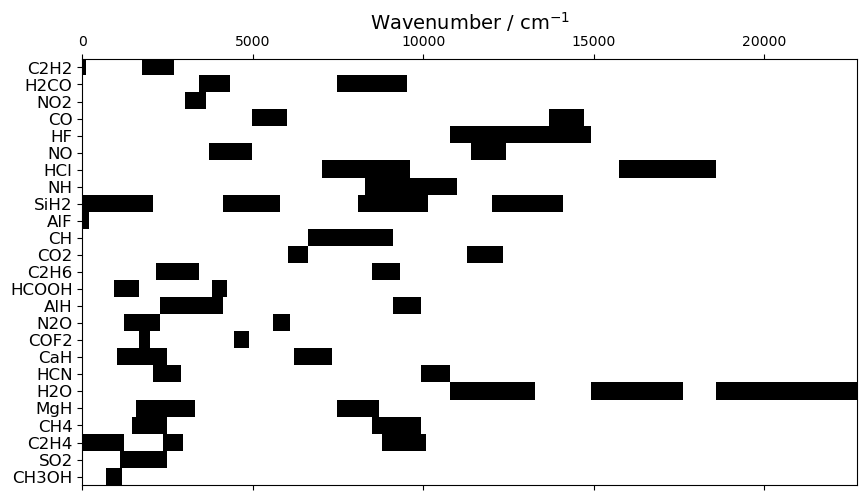

In [11]:
fig, ax = plt.subplots(figsize=(10,10))

fig.canvas.draw()

ax.spy(storage_mtx, aspect = 1/0.002)

ax.set_yticks(np.arange(0,len(storage_mtx),1))
ax.set_yticklabels(Compounds.keys(), fontsize=12)
#ax.set_xticklabels([int(W[x]) for x in [-500, 0,5000,10000,15000,20000,25000]], fontsize=14)

ax.set_xlabel('Wavenumber / cm$^{-1}$', fontsize=14)
ax.xaxis.set_label_position('top') 

plt.show()

In [12]:
# Note that the remove_background still take bounds_clip as input. This doesn't do anything, I will get round to removing soon.

# Simple background removal and subsetting.
#residual_spectra = remove_background(S_l, {}, W)
# Subsetting of the absorption spectra.

reference_spectra = storage_mtx[:, ~np.all(storage_mtx == 0, axis=0)]

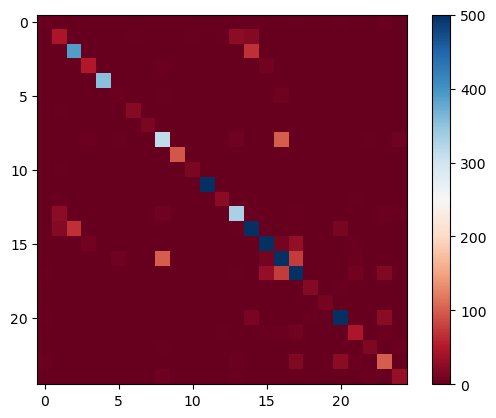

In [13]:
plt.imshow(reference_spectra @ reference_spectra.T, interpolation="nearest", cmap=plt.cm.RdBu, vmax=500)
plt.colorbar()


In [14]:
deselect = np.full(len(W), True)

for i in range(len(residual_spectra)):
    arr = [index for (index, item) in enumerate(residual_spectra[i]) if item != item]
    for i in arr:
        deselect[i] = False

In [15]:
residual_spectra = residual_spectra[:,deselect]
reference_spectra = reference_spectra[:,deselect]
W = W[deselect]

In [16]:
for tstep in [0, 1, 300, 350]:
    x_sol = np.linalg.lstsq(reference_spectra@reference_spectra.T, residual_spectra[tstep, :]@reference_spectra.T, rcond=None)
    print(tstep, "=>", x_sol[0])

0 => [ 0.01154499  0.06264365  0.0204433   0.00216896  0.00262117  0.04982899
 -0.00472825  0.00313606  0.00604291  0.0029076  -0.00588342  0.01246915
  0.02611481  0.02272675  0.00247036  0.00197281  0.00529089  0.00093094
  0.02700947  0.60429561  0.00726961  0.00119457  0.03066435  0.03305498
 -0.00135446]
1 => [ 8.13548583e-03  4.38571898e-02  1.39346389e-02  1.78320330e-03
  1.90806107e-03  3.41656245e-02 -2.76569303e-03  2.65268328e-03
  4.35859278e-03  2.51415239e-03 -3.22919600e-03  1.07376362e-02
  1.91855736e-02  1.55984350e-02  1.68330385e-03  1.58603523e-03
  3.71961208e-03  6.54724728e-04  1.95770409e-02  4.45119861e-01
  4.96931357e-03  1.30811947e-03  2.29103156e-02  2.25953978e-02
 -1.11268542e-04]
300 => [-0.03878274 -0.17669922 -0.05461793 -0.14255164 -0.00636424 -0.12877708
  0.01083537 -0.00625672 -0.02084174 -0.00676469  0.01719377 -0.17501058
 -0.0799572  -0.06613431 -0.0064822  -0.01658186 -0.01430245 -0.00275249
 -0.07206109 -1.15394488 -0.01843444 -0.02508115 -

In [17]:
x_sol,sigma, C = temporally_regularised_inversion(reference_spectra, residual_spectra,
                                                  0.00001)

MemoryError: Unable to allocate 142. MiB for an array with shape (37156644,) and data type float32

In [ ]:
# x_sol = np.load('x_sol.npy')
# sigma = np.load('sigma.npy')
# Compounds = np.load('Compounds.npy', allow_pickle=True)
# Compounds = Compounds.item()

# bad = ['SiH', 'CaF', 'SiS', 'CH3Br', 'H2S', 'BeH', 'SH', 'TiH', 'LiF', 'ClO']

# for b in bad:
#     Compounds.pop(b)

In [ ]:
import colorsys

def HSVToRGB(h, s, v): 
    (r, g, b) = colorsys.hsv_to_rgb(h, s, v) 
    return (int(255*r), int(255*g), int(255*b)) 

def getDistinctColors(n): 
    huePartition = 1.0 / (n + 1) 
    return (HSVToRGB(huePartition * value, 1.0, 1.0) for value in range(0, n))

def rgb2hex(rgb):
    return "#{:02x}{:02x}{:02x}".format(rgb[0],rgb[1],rgb[2])

def hilo(a, b, c):
    if c < b: b, c = c, b
    if b < a: a, b = b, a
    if c < b: b, c = c, b
    return a + c

def complement(col):
    r, g, b = col[0], col[1], col[2]
    k = hilo(r, g, b)
    return tuple(k - u for u in (r, g, b))

In [ ]:
# converts to ppm

nt = residual_spectra.shape[0]

for i, spc in enumerate(list(Compounds.keys())):
    f_d = Compounds[spc]['PPM_RelativeAbsorbance']
    f =  scipy.interpolate.interp1d(f_d[1], f_d[0])
    for j in range(len(x_sol[i*nt:(i+1)*nt])):
        sigma[i*nt:(i+1)*nt][j] *= (f(abs(x_sol[i*nt:(i+1)*nt][j]))/abs(x_sol[i*nt:(i+1)*nt][j]))
        x_sol[i*nt:(i+1)*nt][j] = f(abs(x_sol[i*nt:(i+1)*nt][j]))

In [ ]:
fig, axs = plt.subplots(nrows=8, ncols=2, figsize= (20,15),sharex=True)
axs = axs.flatten()
nt = residual_spectra.shape[0]
#colours = getDistinctColors(len(labels_new))

for i, spc in enumerate(list(Compounds.keys())):
    try:
        col = next(colours)
        c = rgb2hex(col)
        c_comp = rgb2hex(complement(col))
        axs[i].plot(np.arange(nt), new_sol[i*nt:(i+1)*nt], color = 'red')
        axs[i].fill_between(np.arange(nt), new_sol[i*nt:(i+1)*nt] - 0.5*np.sqrt(sigma[i*nt:(i+1)*nt]),
                            new_sol[i*nt:(i+1)*nt] + 0.5*np.sqrt(sigma[i*nt:(i+1)*nt]),
                            color= "0.8")
        axs[i].set_title(spc, fontsize=20)
        axs[i].tick_params(labelsize=20)
    except:
        continue

fig.text(0.5, -0.001, 'Time Step', ha='center', fontsize=20)
fig.text(-0.003, 0.5, '$\sim$ Concentration (ish)', va='center', rotation='vertical', fontsize=20)

fig.tight_layout()

In [ ]:
len(reference_spectra)

In [ ]:
fig, axs = plt.subplots(nrows=13, ncols=2, figsize= (30,15),sharex=True)
axs = axs.flatten()
nt = residual_spectra.shape[0]
#colours = getDistinctColors(len(labels_x))

for i, spc in enumerate(list(Compounds.keys())):
    print(i,spc)
    try:
        axs[i].plot(np.arange(nt), x_sol[i*nt:(i+1)*nt], color = 'red')
        axs[i].fill_between(np.arange(nt), x_sol[i*nt:(i+1)*nt] - 0.5*np.sqrt(sigma[i*nt:(i+1)*nt]),
                            x_sol[i*nt:(i+1)*nt] + 0.5*np.sqrt(sigma[i*nt:(i+1)*nt]),
                            color= "0.8")
        axs[i].set_title(spc, fontsize=20)
        axs[i].tick_params(labelsize=20)
    except:
        print(spc)
        continue
    
fig.text(0.5, -0.001, 'Time Step', ha='center', fontsize=20)
fig.text(-0.003, 0.5, '$\sim$ Concentration (ish)', va='center', rotation='vertical', fontsize=20)

fig.tight_layout()

In [ ]:
np.save('x_sol2.csv', x_sol)

In [ ]:
np.save('sigma2.csv',sigma)